## Welcome to the Dynamical Systems Tutorial on Equilibria!

This notebook is meant to provide an introduction to Dynamical Systems Theory (DST), apply the basic tenets to identify equilibrium points in one and two dimensions, and provide code for using the tools in conjunction with other applications. First, background to DST will be provided along with a series of Intuition Checks for user understanding. Then, the notebook will describe dynamics in one and two dimensions, followed by an unguided example. Some familiarity with basic calculus and linear algebra is assumed, but resources are provided for those who need a refresher. The notebook should take about an hour to work through although users may expect to spend more time if they follow some of the external links provided throughout the notebook. We also encourage feedback so we can improve the notebook for future users!

## Learning Objectives

### 1. Become Familier with Dynamical Systems Theory
By the end of this notebook, you should be able to have a basic conceptual understanding of how Dynamical Systems Theory can be applied to a variety of scales and systems.
#### a. Equilibrium Points
You should understand what an equilibrium point is and why it is a special case in a system of equations. You should also be able to find equilibrium points in one and two dimensions.
#### b. Stability
You should understand what the stability of an equilibrium point means and how to determine the stability of an equilibrium point in one and two dimensions.
#### c. System Behavior
You should understand how equilibrium points and their stability determine the behavior of trajectories in a dynamical system.

### 2. Understand ODE Modeling in Various Contexts
You should understand how ordinary differential equations (ODE) can be used to model dynamical systems and how the previously described concepts are realized in ODE models. You should also have a handle on a couple of calculus and linear algebra tools are applied in ODE models.

### 3. Be able to use DST in python
You should be able to follow the python code in this notebook and implement it for your own purposes. The extension of the tools we provide here to your own applications is one of the most important features we hope to provide. You should also understand the connections between the code and the concepts as described above.

### Disclaimer
It is important to note that there are a few things that this notebook does not offer an exhaustive account of equilibria, which would necessitate numerically solving for what is called the "saddle manifolds." These play an important role, especially in 2D where they carve out the basins of attraction. There are also limit cycles in 2D, which we do not talk about, and 3D+ systems there are toroidal and chaotic attractors. All of this is beyond the scope of the current notebook, but, nonetheless, we hope that this notebook provides an accessible starting point!

## Load Packages

In [1]:
import numpy as np
import tellurium as te
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.optimize as opt
import sympy
from math import sqrt
import ipywidgets as widgets 
from IPython.display import display

## Section 1: What is a Dynamical System?

In general, a dynamical system is best defined as any system that changes in time. These systems can be deterministic, stochastic, spatial, aspatial, discrete, or continuous. They can also apply at many scales of space and time, evidenced by their use across the fields of physics, chemistry, biology, and ecology. Since we are assuming nanoHub users are particularly interested in cellular biology and cehmistry, this introduction will be focused on deterministic, continuous systems that best apply.

It is sometimes possible to solve a system of ordinary differential equations (ODEs) analytically in closed form (pen and paper work fine), but this is often not the case for sufficiently nonlinear systems, and most phenomena in nature fall into this difficult category! Not only that, but even within the cases where it is possible to solve non-numerically, sometimes things can get unwieldly very quickly. For that reason, this quick-and-dirty introduction will emphasize how to begin dealing with dynamical systems numerically as well as analytically.

### Systems of Ordinary Differential Equations (ODEs)

In order to understand a system of ODEs, it is important to first understand the structure of an ODE in general. An ODE describes the time-evolution of a state-variable (purple) a moving part in the dynamical system. The parts of the equation that remain fixed are called parameters (orange). Sometimes the initial state of the system is also called a parameter, although this terminology is less universal. An ODE's right hand side, the function that governs it, can take any number of parameters and can also take each state-variable of the system as an input, or no state at all.

$$
\frac{𝑑A}{𝑑𝑡}= \color{orchid}{A} \color{orange}{(0.3)}
$$

A dynamical system is comprised of a system of one or more ODEs with no upper bound. Each state-variable of the system has its own governing ODE, and the number of ODEs there are is used to define the dimensionality of the system.For example, consider the following set of equations with the same color scheme as above:

$$
\frac{𝑑A}{𝑑𝑡}= \color{orchid}{A} (\color{orange}{𝑃1})
$$

$$
\frac{𝑑B}{𝑑𝑡}= \color{orchid}{B} (\color{orange}{𝑃2}) − \color{orchid}{A} (\color{orange}{𝑃3})
$$

Here we have a two-dimensional dynamical system with three parameters. The state of the system is a represented by the states of all of its state-variables. In principle, there is no upper bound on the dimensionality of systems we can model. For example, imagine that we wanted to make a model of the human brain at the level of individual cells. Just accounting for neurons (note that other cells, such as glia, also play important roles) this gives a lower bound for a ~100-billion-dimensional dynamical system! There is also the question of how biophysically realistic we want the neurons to be. If we are hoping to use neural components that have spiking behavior, this often assumes that each neuron on its own is governed by at least two ODEs. Note that, as modelers, our job is not to reproduce the exact thing we are trying to understand, but to capture some essence of it that offers new insights.

### Intuition Check!
For the following systems, how many dimensions would my ODE model be?

1. I want to understand how the human population grows and shrinks over time. For simplicity, I only consider rates of birth and death.

In [2]:
@widgets.interact(selection = widgets.Dropdown(options=['','1','2','3+']))

def I_check_1(selection):
    if selection == '1':
        print("Correct! In this case, the one state variable is the human population, while birth and death rates are parameters.")
    elif selection == '':
        print('')
    else:
        print("Incorrect, try again.")

interactive(children=(Dropdown(description='selection', options=('', '1', '2', '3+'), value=''), Output()), _dom_classes=('widget-interact',))

2. I want to model how the populations of deer and wolves interact over time.

In [3]:
@widgets.interact(selection = widgets.Dropdown(options=['','1','2','3+']))

def I_check_2(selection):
    if selection == '2':
        print("Correct! In this case, the two state variables are the populations of deer and wolves.")
    elif selection == '':
        print('')
    else:
        print("Incorrect, try again.")

interactive(children=(Dropdown(description='selection', options=('', '1', '2', '3+'), value=''), Output()), _dom_classes=('widget-interact',))

### Visualizing Dynamical Systems

In general, we can talk about a dynamical system in terms of time series and state-space. When we are looking at a time series, the x-axis is for time, and the y-axis is for the value of the state variables. In this case, each state variable has its own line. Taking a two dimensional system:

$$
\frac{𝑑A}{𝑑𝑡}=𝑓(...) \\
$$

$$
\frac{𝑑B}{𝑑𝑡}=𝑓(...)
$$

We might get something like the following time-series:

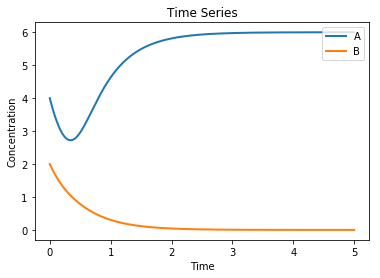

In [4]:
r = te.loada('''
    J1: -> A; k1/(1+B^n1) - k2*A;
    J2: -> B; k3/(1+A^n2) - k4*B;
    A = 4; B = 2;
    k1 = 12; k3 = 12; k2 = 2; k4 = 2
    n1 = 4; n2 = 4
''')
m = r.simulate(0,5,500)
te.plotArray(m, show=False, title="Time Series", xlabel="Time",ylabel="Concentration",labels=("A","B"), resetColorCycle=False)
plt.show()

As we can see, the dynamics of A and B play out and reach a fixed point relative to one another over time. Is there a way we can fit both trajectories in a more holistic picture?

The state-space of a dynamical system can provide such a picture. Instead of plotting our state variables with respect to time, we could plot how the states change with respect to one another as time passes. The same initial conditions above would look like this in state space:

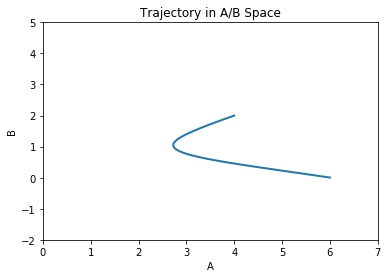

In [5]:
r.reset()
m = r.simulate(0,5,500,['A','B'])
te.plotArray(m, title="Trajectory in A/B Space", xlabel = 'A', ylabel = 'B', xlim=((0, 7)),ylim=((-2, 5)))

So, beginning at the point (4,2), the system first dips in A before rising to 6, while B continuously decreases to 0. This is a **trajectory** in the state space of the system. These trajectories visualize the dynamics of our state variables and in turn the behavior of our system. 

### What can trajectories look like in DST?

In general, there are two ground rules we have to keep in mind when talking about the time-evolution of a deterministic and continuous dynamical system:

**Existence and Uniqueness Theorem**: For any initial value of the state-variables, there is a unique solution. This means trajectories cannot cross and a given value will always result in the same trajectory.

**Smoothness of the Trajectory**: Trajectories in an ODE model work within a continuous state-space, and therefore should not show the jagged lines characteristic of discrete jumps.

So, in general, we should not expect any sharp corners or crossing lines. That being said, trajectories may leave the state space (given that they may move the value of the state variables beyond the region we are examining) and they may stop (which will be especially important as we move to fixed points!).

Lastly, it is important to briefly discuss positive and negative space. Dynamical System Theory and ODE models support the analysis of phenomena that occur in negative space. As such trajectories and even equilibrium points can be negative. It is important to consider how this relates to the physical system that one is modeling. In most biological, chemical, and generally physical cases, negative values are not possible (with some exceptions such as electric charge). The fact that these models allow for negative phenomenon thus may appear to be problematic.

However, it is important to remember that (a) these are models of physical systems that are naturally incomplete, (b) that models can apply in certain ranges and not apply in others, and (c) that scientists should always consider if their models and certain cases they present are physically supported before drawing any conclusions. Modeling without any grounding can lead to flawed theory and misleading hypotheses. A careful weaving of modeling and experimental data is the best way to ensure that the models we use are grounded in reality. 

So, throughout this notebook, we will be showing models that include negative values. However, the features of these models can occur in positive space in other models, and we mostly include negative space to the end of providing code that can function in both positive and negative space.

From here, we have the building blocks to describe dynamics in one and two dimensions.

## Section 2: Dynamics in One Dimension

When we formalize dynamical systems, the number of dimensions of the system corresponds to the number of state variables in that system, and in turn the number of ODEs we need to define to describe the change of those state variables. So, in a one-dimensional case, we need one ODE. Consider the following equation that describes the change in state variable A over time:

$$
\frac{𝑑A}{𝑑𝑡}= -A^3 + 5A 
$$

How does the behavior of this system unfold over time? As a first pass, we can examine time series for different initial values of A:

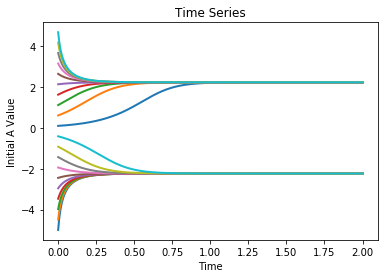

In [6]:
rr = te.loada ('''
    J1: ->A ; -A^3+ d*A
    d=5;
    Perturb=0
    Pert_time=50
    at (time>Pert_time): A=A+Perturb
    at (A<0): A=0.01
''')
for A0 in np.arange(-5,5,0.51):
    rr.resetAll()
    rr.A=A0
    m = rr.simulate(0, 2, 1000)
    p = te.plotArray(m, show=False, title="Time Series", xlabel="Time",ylabel="Initial A Value", resetColorCycle=False)
plt.show()

It appears that after a short time the system converges on one of two values of A around 2 and -2. In other words, at these points the state of A is **no longer changing**, which indicates something special about this point in our system. 

Points in dynamic systems where there are no more dynamics, where the state no longer changes over time, are known as **equilibrium points**. A simple way to solve for this analytically would be to take our equation from before, set it equal to zero (to where it is not changing), and solve for what values of A this is true:

$$
-A^3 + 5A = 0 \\
-A * (A^2 - 5) = 0 \\
Solutions: A = 0, \ A = \sqrt{5}, \ A = -\sqrt{5}
$$

We can also do this with code:

In [7]:
def fun(x):
    return [x[0]**3  + 5 * x[0]]

opt.root(fun, [0])

    fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 3
     qtf: array([0.])
       r: array([-5.])
  status: 1
 success: True
       x: array([0.])

The algebra has given us three solutions, but it seems that there are only two outcomes from our time series. How can this be? 

This is because equilibrium points have different **stabilities**. **Stable equilibrium points** are those where initial conditions adjacent to that point return to that point while **unstable equilibrium points** are those where the same initial conditions lead the trajectory to move away from the point. 

Formally, we can solve for the stability of the solutions we found above by assessing the slope of the function in the neighborhood of (close to) the equilibrium point. To this end, let us consider the **Taylor Expansion**. Near a given point, any smooth function can be represented as:

$$
f(x) \approx f(x_0) + f'(x_0)(x-x_0) + \frac{f''(x_0)(x-x_0)^2}{2!} + ...
$$

This **Taylor Series** is an infinite sum of terms of any functions derivatives at a single point. It basically allows us to linearize around a certain equilibrium point to determine its stability. First, because the first term of the series is the point we are already on, we can remove the first term and reduce the series to:

$$
f(x) \approx f'(x_0)(x-x_0) + \frac{f''(x_0)(x-x_0)^2}{2!} + ...
$$

For the sake of stability analysis, we can collapse this infinite series into its first term:

$$
f(x) \approx f'(x_0)(x-x_0)
$$ 

This approximation is equivalent to the slope of the function at equilibrium, the sign of which provides us with stability information. If $f'(x_0) < 0$, the perturbation will eventually decay to 0, leaving us with no long-term difference between the equilibrium point and the perturbed point. As previously described, this implies a stable equilibrium point. Conversely, if $f'(x_0) > 0$, the perturbation will grow exponentially, implying an unstable equilibrium point. The magnitude of $f'(x_0)$ in either case tells us how quickly that return to or departure from the equilibrium point will occur. 

For more practice with derivatives and other calculus techniques relevant to work with dynamical systems, check out [this playlist](https://www.youtube.com/watch?v=WUvTyaaNkzM&list=PL0-GT3co4r2wlh6UHTUeQsrf3mlS2lk6x&ab_channel=3Blue1Brown) from 3Blue1Brown, an excellent resource for visualizing and understanding calculus.

### Intuition Check!
Given the following ODE, what are the equilibrium points and their stability?
$$
f(x) = x^2 - 4
$$ 

In [8]:
@widgets.interact(selection = widgets.Dropdown(options=['','x = 4 (unstable), x = -4 (stable)','x = 4 (stable), x = -4 (unstable)','x = 2 (unstable), x = -2 (stable)','x = 2 (stable), x = -2 (unstable)']))

def I_check_2(selection):
    if selection == 'x = 2 (unstable), x = -2 (stable)':
        print("Correct! The equilibrium points of this one-dimensional system are at x = 2 (unstable) and x = -2 (stable).")
    elif selection == '':
        print('')
    else:
        print("Incorrect. Please try again.")

interactive(children=(Dropdown(description='selection', options=('', 'x = 4 (unstable), x = -4 (stable)', 'x = 4 (stable), x = -4 (unstable)', 'x = 2 (unstable), x = -2 (stable)', 'x = 2 (stable), x = -2 (unstable)'), value=''), Output()), _dom_classes=('widget-interact',))

Importantly, only stable equilibrium points are observable in real systems, as for an unstable equilibrium point to be observed, the system must start at that state and never be perturbed from it. This is why we only see two outcomes in the time series at the beginning of the section. However, if we *reverse time* by swapping the sign of our ODE, we can use our time series to examine unstable equilibria in the same way we used forward time to see the stable equilibria:

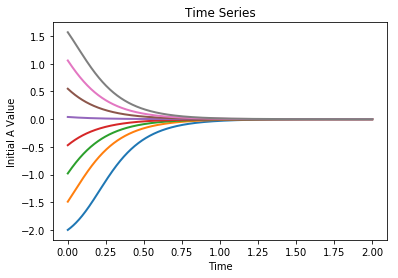

In [9]:
rr = te.loada ('''
    J1: ->A ; A^3 - d*A
    d=5;
''')
for A0 in np.arange(-2,2,0.51):
    rr.resetAll()
    rr.A=A0
    m = rr.simulate(0, 2, 1000)
    p = te.plotArray(m, show=False, title="Time Series", xlabel="Time",ylabel="Initial A Value", resetColorCycle=False)
plt.show()

There is one other possible outcome of our stability analysis, namely when $f'(x_0) = 0$. In this case, the equilibrium point is considered **non-hyperbolic**. In these special cases, the entire dynamical system is going through a characteristic change that will dramatically augment the behavior of trajectories within that system. This kind of change is known as a **bifurcation**. 

Bifurcations occur within **families** of dynamical systems, those that take a similar form with different specific parameter values. Take for example:

$$
\frac{𝑑A}{𝑑𝑡}= -A^3 + 5A + c
$$

where *c* is a parameter that is fixed within a single dynamical system but that changes throughout the family of that system. Let's look at time series for two different values of *c*. 

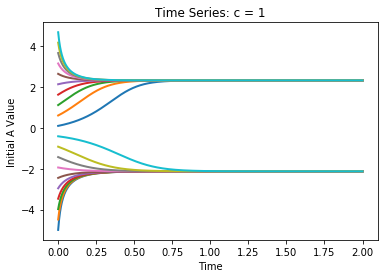

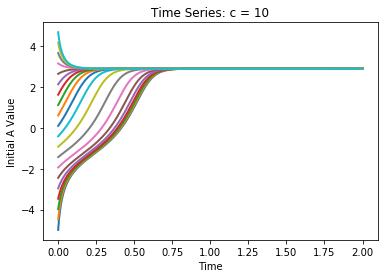

In [10]:
r = te.loada ('''
    J1: ->A ; -A^3+ d*A + c
    d=5;
    c=1;
    Perturb=0
    Pert_time=50
    at (time>Pert_time): A=A+Perturb
    at (A<0): A=0.01
''')
for A0 in np.arange(-5,5,0.51):
    r.resetAll()
    r.A=A0
    m = r.simulate(0, 2, 1000)
    p = te.plotArray(m, show=False, title="Time Series: c = 1",xlabel="Time",ylabel="Initial A Value", resetColorCycle=False)
plt.show()

for A0 in np.arange(-5,5,0.51):
    r.resetAll()
    r.A=A0
    r.c=10
    m = r.simulate(0, 2, 1000)
    p = te.plotArray(m, show=False, title="Time Series: c = 10",xlabel="Time",ylabel="Initial A Value", resetColorCycle=False)
plt.show()


By changing *c*, all of a sudden we only have one long-term observed outcome in the system! This is because the system has undergone a bifurcation in which the unstable equilibrium point and one of the stable equilibrium points have collided and dissappeared. We can better visualize this change by examining a **bifurcation diagram**, which displays the equilibrium values as we vary the parameter *c*:

In [11]:
def bifurcation_plot(f,r,x,tolerance,rlabel='r'):
    """ produce a bifurcation diagram for a function f(r,x) given
        f and its partial derivative f_x(r,x) over a domain given by numpy arrays r and x
        
        f(r,x)  :  RHS function of autonomous ode dx/dt = f(r,x)
        f_x(r,x):  partial derivative of f with respect to x
        r       :  numpy array giving r coordinates of domain
        x       :  numpy array giving x coordinates of domain
        rlabel  :  string for x axis parameter label
    """

    # set up a mesh grid and extract the 0 level set of f
    R,X = np.meshgrid(r,x)
    plt.figure()
    CS = plt.contour(R,X,f(R,X),[0],colors='k')
    plt.clf()

    # Compute the derivative with Sympy
    x1 = sympy.Symbol('x')
    r1 = sympy.Symbol('r')
    f_x = sympy.diff(f(r1,x1),x1)
    f_x = sympy.lambdify((r1,x1),f_x)
    
    c0 = CS.collections[0]
    # for each path in the contour extract vertices and mask by the sign of df/dx
    for path in c0.get_paths():
        vertices = path.vertices
        vr = vertices[:,0]
        vx = vertices[:,1]
        mask = f_x(vr,vx)
        stable = mask < 0.
        unstable = mask > 0.
        bif = abs(mask) < tolerance
        
        # plot the stable and unstable branches for each path

        plt.plot(vr[stable],vx[stable],marker='h',color='b',markersize=1,linestyle='None')
        plt.plot(vr[unstable],vx[unstable],marker='h',color='r',markersize=1,linestyle='None')
        plt.plot(vr[bif],vx[bif],marker='h',color='black',markersize=8,linestyle='None')
        
    
    plt.xlabel('parameter {0}'.format(rlabel))
    plt.ylabel('state variable x')
    plt.legend(('stable','unstable','bifurcation'),loc='best')
    plt.xlim(r[0],r[-1])
    plt.ylim(x[0],x[-1])
    plt.show()
    

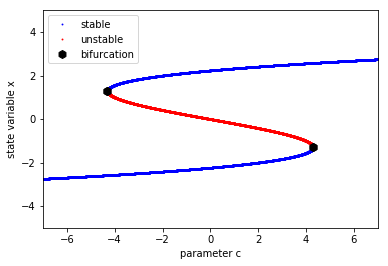

In [12]:
## First, define your function!
f = lambda h,x: -x**3 + 5*x + h
## Next, define the range of the parameter h and the range of state variable x
## note that the third value of the linspace functions is the number of points in the mesh, so values that are too
## low may miss bifurcation points. Conversely, values that are too high will take a long time to compute.
h = np.linspace(-7,7,10000)
x = np.linspace(-5,5,10000)
## Set your tolerance here. Tolerance can be adjusted in correspondence with the resolution of the plot below to ensure
### you are getting the correct approximations of the bifurcation points. 
tolerance = 0.01
## Finally, call the function to plot the bifurcation diagram
bifurcation_plot(f,h,x,tolerance,rlabel='c')

As we move along the *c* axis, we can see the birth of two equilibria in a **fold bifurcation** followed by the elimination of two equilibria in a second fold bifurcation.

### Intuition Check!
How many equilibrium points are there at c = 2 and c = 8?

In [13]:
@widgets.interact(selection = widgets.Dropdown(options=['','0,0','0,1','1,0','1,1','3,1','1,3','3,3']))

def I_check_2(selection):
    if selection == '3,1':
        print("Correct!")
    elif selection == '':
        print('')
    else:
        print("Incorrect. Please try again.")

interactive(children=(Dropdown(description='selection', options=('', '0,0', '0,1', '1,0', '1,1', '3,1', '1,3', '3,3'), value=''), Output()), _dom_classes=('widget-interact',))

### Intuition Check!
A bifurcation occurs when...

In [14]:
@widgets.interact(selection = widgets.Dropdown(options=['','... the system of equations equals 0.','... the number of equilibrium points or their stability changes.','... the number of equilibrium points is 0.']))

def I_check_2(selection):
    if selection == '... the number of equilibrium points or their stability changes.':
        print("Correct!")
    elif selection == '':
        print('')
    else:
        print("Incorrect. Please try again.")

interactive(children=(Dropdown(description='selection', options=('', '... the system of equations equals 0.', '... the number of equilibrium points or their stability changes.', '... the number of equilibrium points is 0.'), value=''), Output()), _dom_classes=('widget-interact',))

Now that we have built intuitions about equilibrium points, their stability, and bifurcations, we will move to two dimensions to visually and analytically examine other features of dynamical systems and how the interaction of two state variables play out.

## Section 3: Dynamics in Two Dimensions

This time, let's consider a system of two equations:

$$
\frac{𝑑A}{𝑑𝑡}= X^3 + Y^2 - 0.25
$$

$$
\frac{𝑑B}{𝑑𝑡}= -Y^3 + X
$$

As we did before, we can examine the behavior of this system over time by plotting the solution trajectories of both variables in a **phase space**. This is a two-dimensional space where the x-axis represents the state of variable A and the y-axis represents the state of variable B.

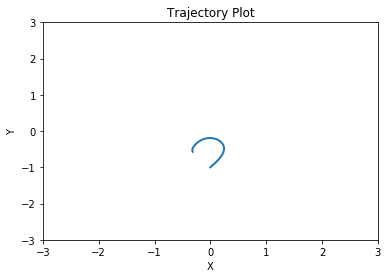

In [15]:
r = te.loada('''
    J1: -> A; A^3 + B^2 - 0.25;
    J2: -> B; -B^3 + A;
    A = 0
    B = -1
''')
m = r.simulate(0,5,500,['A','B'])
te.plotArray(m, title="Trajectory Plot", xlabel = 'X', ylabel = 'Y', xlim=((-3, 3)),ylim=((-3, 3)))

If we do this repeatedly, we can display the behavior of many initial conditions of the system over time. The resulting plot of trajectories is known as a **flow diagram**.

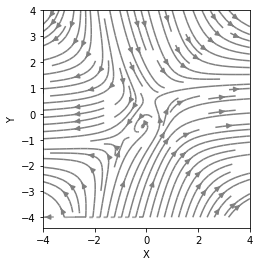

In [16]:
x = np.linspace(-4,4,3000)
y = np.linspace(-4,4,3000)
X,Y = np.meshgrid(x, y)

U = X**3+Y**2-0.25
V = -Y**3+X
F1 = ((U)<0.0000000000001) & ((U)>-0.0000000000001).any()
F2 = ((V)<0.0000000000001) & ((V)>-0.0000000000001).any()
fig, ax = plt.subplots()
ax.set_aspect('equal', 'box')
ax.streamplot(X, Y, U, V, color='gray')
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

While these diagrams are informative, they do not provide us with any quantitative information about possible equilibria in the system. This requires a more careful analysis that we will work through below. 

In one dimension, we just had to look for when a single rate equation was equal to zero, but to find equilibria in two dimensions, we need to look for when both rate equations are equal to zero! 

$$
X^3 + Y^2 - 0.25 = 0
$$

$$
-Y^3 + X = 0
$$

The regions within state-space along which the rate equation of a two-dimensional system is equal to zero is referred to that equation's **nullcline**. Both equations have their own, and looking for where they intersect graphically tells us where the system is at equilibrium. Sometimes nullclines can be solved for analyitically, but in many nonlinear systems this is not possible. When this is the case, we can numerically approximate the nullclines within some tolerance, as we will demonstrate for you here!

 First, we should define our ODEs:

In [17]:
# DEFINE YOUR ODEs HERE:

## ODE for State Variable 1
def S1_ODE(X,Y):
    S1_M = X**3+Y**2-0.25
    return(S1_M)

## ODE for State Variable 2
def S2_ODE(X,Y):
    S2_M = -Y**3+X
    return(S2_M)

Then, we can plot the nullclines:

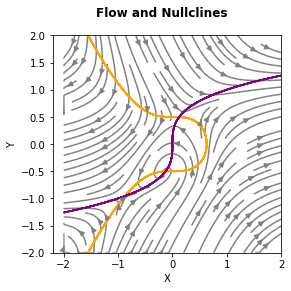

In [18]:
# CODE FOR NULLCLINE AND FLOW

## To use this function, the user needs to define both of their ODEs as a function of X and Y, with the names S1_ODE and S2_ODE,
## respectively. These ODEs then get used to generate a flow and nullclines in a specified range. Two important inputs are the 
## resolution and the tolerance, which need to be quite large and small respectively in order to get smooth lines and a 
## reliable plot. 

# FUNCTION FOR NULLCLINES AND FLOW
def gen_null_flow(min_S1, max_S1, min_S2, max_S2, resolution, tolerance):

    x = np.linspace(min_S1, max_S1, resolution)
    y = np.linspace(min_S2, max_S2, resolution)
    X,Y = np.meshgrid(x, y)

    U = S1_ODE(X,Y)
    V = S2_ODE(X,Y)


    F1 = ((S1_ODE(X,Y)<tolerance) & (S1_ODE(X,Y)>-tolerance))
    F2 = ((S2_ODE(X,Y)<tolerance) & (S2_ODE(X,Y)>-tolerance))


    fig, ax = plt.subplots()
    ax.streamplot(X, Y, U, V, color='gray')
    ax.contour(X,Y,F1, colors='orange')
    ax.contour(X,Y,F2, colors='purple')
    ax.set_aspect('equal', 'box')
    fig.suptitle('Flow and Nullclines',fontweight="bold")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

gen_null_flow(-2, 2, -2, 2, 4000, 0.001)

Sometimes, the intersections are referred to as **fixed points** as well as equilibria.

### Intuition Check!
Where two nullclines meet, we should expect a trajectory to...

In [19]:
@widgets.interact(selection = widgets.Dropdown(options=['','... increase in A and B.','... increase in A and decrease in B.','... decrease in A and increase in B.','... decrease in A and B.','... not move.']))

def I_check_2(selection):
    if selection == '... not move.':
        print("Correct!")
    elif selection == '':
        print('')
    else:
        print("Incorrect. Please try again.")

interactive(children=(Dropdown(description='selection', options=('', '... increase in A and B.', '... increase in A and decrease in B.', '... decrease in A and increase in B.', '... decrease in A and B.', '... not move.'), value=''), Output()), _dom_classes=('widget-interact',))

### Intuition Check!
What is the equilibrium point of the following system:

$$
\frac{𝑑A}{𝑑𝑡}= B - A \\
$$ 
$$
\frac{𝑑B}{𝑑𝑡}= B^2 - A
$$

In [20]:
@widgets.interact(selection = widgets.Dropdown(options=['','0,0 and 0,1','0,0 and 1,0','0,1 and 1,0','0,0 and 1,1','1,0 and 1,1','0,1 and 1,1']))

def I_check_2(selection):
    if selection == '0,0 and 1,1':
        print("Correct!")
    elif selection == '':
        print('')
    else:
        print("Incorrect. Please try again.")

interactive(children=(Dropdown(description='selection', options=('', '0,0 and 0,1', '0,0 and 1,0', '0,1 and 1,0', '0,0 and 1,1', '1,0 and 1,1', '0,1 and 1,1'), value=''), Output()), _dom_classes=('widget-interact',))

Here we introduce some code for numerically finding fixed points in a two equation system. This means that you have to make some guesses based on the plot above about where the equilibria might be (Hint: where do the nullclines intersect?).

In [21]:
#####################################################################################

# CODE FOR FIXED POINTS

# WORKFLOW:
# 1. Take in a matrix of proposed fixed points.
# 2. For each proposed fixed point, numerically solve for the root.
# 3. Return the numerical solutions as a corresponding matrix.
# 4. For any numerical solutions beneath a certain threshold, set them to zero.

def equil(state):
    return [S1_ODE(state[0],state[1]), S2_ODE(state[0],state[1])]

# Here, you need to provide the numerical solver with some guesses. These guesses could have been found qualitatively
# (by looking at the nullclines). Any guesses that converge on the same solution will just return that solution.  
guesses = np.array([[0, 0.5], [0, -0.5], [-1, -1]])

def find_eqs(guesses):
    sols = np.zeros((len(guesses),2))
    for i in range(len(guesses)):
        sols[i] = opt.fsolve(equil, guesses[i])
    sols[abs(sols) < 0.000001] = 0
    return sols

roots = find_eqs(guesses)

print(roots)

[[ 0.12358695  0.49810879]
 [-0.12652208 -0.50202126]
 [-0.87179741 -0.95529725]]


Determining the stability of equilibrium points in two dimensions is trickier than doing so in one dimension. We can still use the Taylor expansion to linearize the system around a given equilibrium point, but we now have two equations to consider and therefore our purturbation will be a vector in two dimensions rather than one. This requires us to consider the **Jacobian matrix** of the system, which is a matrix of partial derivatives of the system's equations with respect to each state variable.

Using the Jacobian matrix requires some detours into linear albegra that we will briefly touch on below. For those interested, a more thorough treatment of this topic can be found in [this video](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/jacobian/v/the-jacobian-matrix) from Khan Academy.

The Jacobian matrix is a square matrix with the same number of rows and columns as the number of state variables in the system. Each element of the matrix is the partial derivative of one equation with respect to one state variable. A partial derivatie is the derivative of a function with respect to one of its variables while holding all other variables constant. For example, the element in the first row and first column of the Jacobian matrix is the partial derivative of the first equation ($\frac{dA}{dt}$) with respect to the first state variable (A). 

$$
\frac{\partial f_1}{\partial X} = \frac{d}{dX} (X^3 + Y^2 - 0.25)
$$

$$
\frac{\partial f_1}{\partial X} = 3X^2
$$

The entire Jacobian matrix in the case of our example function looks like this:

$$
\begin{bmatrix}
\frac{\partial f_1}{\partial X} = 3X^2 & \frac{\partial f_1}{\partial Y} = 2 \\
\frac{\partial f_2}{\partial X} = 1 & \frac{\partial f_2}{\partial Y} = -3Y^2
\end{bmatrix}
$$

Here is some code that computes the Jacobian automatically using Sympy:

In [22]:
f1 = lambda x,y: x**3 + y**2 - 0.25
f2 = lambda x,y: -y**3 + x
F = [f1,f2]

def Jacobian(system):
    x,y = sympy.symbols('x y')
    f1 = system[0]
    f2 = system[1]
    J = sympy.Matrix([[sympy.diff(f1(x,y),x),sympy.diff(f1(x,y),y)],[sympy.diff(f2(x,y),x),sympy.diff(f2(x,y),y)]])
    return(J)

J = Jacobian(F)
J

Matrix([
[3*x**2,     2*y],
[     1, -3*y**2]])

Importantly, this Jacobian matrix is fixed for our system of equations, it will not change as we examine the stability of different equilibrium points. 

Before going forward it is important that we understand what the determinant and the trace of a matrix are. The determinant of a matrix is a single number that is calculated by multiplying the diagonal elements of the matrix and subtracting the product of the off-diagonal elements. For example, the determinant of the following matrix is:

$$
\det
\begin{bmatrix}
1 & 2 \\
3 & 4
\end{bmatrix}
= 1 \times 4 - 2 \times 3 = -2
$$

The trace of a matrix is the sum of the diagonal elements. For example, the trace of the following matrix is:

$$
\text{trace}
\begin{bmatrix}
1 & 2 \\
3 & 4
\end{bmatrix}
= 1 + 4 = 5
$$

These calculations are common in matrix algebra and will serve an important purpose in our stability analysis below. For lessons on matrix algebra in general, check out [this channel](https://www.khanacademy.org/math/linear-algebra/matrix-transformations) from Khan Academy.

Now, back to the Jacobian matrix. Extracting stability information with Jacobian matrix requires us to calculate the **eigenvalues** of the matrix. The eigenvalues of a matrix (denoted by $\lambda$) the values that, when multiplied by the matrix, result in a matrix that is scaled by that value. We can solve for the eigenvalues of the Jacobian matrix using the following general formula:

$$
\lambda = \frac{\text{trace} + \sqrt{\text{trace}^2 - 4 \det}}{2}
$$

In the case of our example system, the derivation of this general form looks something like this:

$$
(
\det
\begin{bmatrix}
3A^2  & 2 \\
1 & -3B^2
\end{bmatrix}
-
\lambda
\begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix}
) = 0
$$

$$
(
\det
\begin{bmatrix}
3A^2 - \lambda & 2 \\
1 & -3B^2 - \lambda
\end{bmatrix}
) = 0
$$

And after a lot of algebra...

$$
\lambda = \frac{3*(A - B)*(A + B)}{2} \pm \frac{\sqrt{9*A^4 + 18*A^2*B^2 + 9*B^4 + 8*B}}{2}
$$

We can verify this using the code below:

In [23]:
list(J.eigenvals(rational=False))

[3*(x - y)*(x + y)/2 - sqrt(9*x**4 + 18*x**2*y**2 + 9*y**4 + 8*y)/2,
 3*(x - y)*(x + y)/2 + sqrt(9*x**4 + 18*x**2*y**2 + 9*y**4 + 8*y)/2]

Now, we can substitute our equilbrium point A and B values into this equation to determine stability. There can be three different outcomes depending on the results of this calculation:

1. If the eigenvalues are both positive, the equilibrium point is **unstable**. This means that a slight perturbation from the equilibrium point will result in a trajectory that diverges from the equilibrium point.
2. If the eigenvalues are both negative, the equilibrium point is **stable**. This means that a slight perturbation from the equilibrium point will result in a trajectory that converges back to the equilibrium point.
3. If the eigenvalues are one positive and one negative, the equilibrium point is known as a **saddle**. This kind of equilibrium point is unstable in one direction and stable in the other. A trajectory that starts at the equilibrium point and is perturbed in the direction of the positive eigenvalue will diverge from the equilibrium point. A trajectory that starts at the equilibrium point and is perturbed in the direction of the negative eigenvalue will converge back to the equilibrium point.

Now, let's see if you can determine the stability of our example system!

### Intuition Check!
Solve for the equilibrium points of our example system:

$$
\frac{𝑑A}{𝑑𝑡}= X^3 + Y^2 - 0.25
$$

$$
\frac{𝑑B}{𝑑𝑡}= -Y^3 + X
$$

You should get *three* points. Then, for each of these points determine the stability. 
What stabilities did you get?

In [24]:
@widgets.interact(selection = widgets.Dropdown(options=['','three stable nodes.','two stable nodes and one saddle node.','two stable nodes and one unstable node.','three unstable nodes.','one stable node, one unstable node, and one saddle node.']))
def I_check_2(selection):
    if selection == 'two stable nodes and one saddle node.':
        print("Correct!")
    elif selection == '':
        print('')
    else:
        print("Incorrect. Please try again.")

interactive(children=(Dropdown(description='selection', options=('', 'three stable nodes.', 'two stable nodes and one saddle node.', 'two stable nodes and one unstable node.', 'three unstable nodes.', 'one stable node, one unstable node, and one saddle node.'), value=''), Output()), _dom_classes=('widget-interact',))

We can also solve these problems numerically rather than algebraically. This is to say, instead of doing the analytical work, we can take a guess and allow the dynamics of the system to play out and solve for the real value of equilibrium points. Some code for this is provided here. Here is some code that will help you solve for the stability of equilibrium points using the Jacobian matrix. It extends the previous code for fixed points to include stability information. 

In [25]:
f1 = lambda x,y: x**3 + y**2 - 0.25
f2 = lambda x,y: -y**3 + x
F = [f1,f2]

def find_eqs(guesses):
    sols = np.zeros((len(guesses),2))
    for i in range(len(guesses)):
        sols[i] = opt.fsolve(equil, guesses[i])
    sols[abs(sols) < 0.000001] = 0
    return sols

def equil(state):
    return [S1_ODE(state[0],state[1]), S2_ODE(state[0],state[1])]

def EP_Stability(J, guesses):
    roots = find_eqs(guesses)
    eigenvalues = list(J.eigenvals())
    stabilities = list()
    for p in roots:
        x = p[0]
        y = p[1]
        output = list()
        for e in eigenvalues:
            sub = sympy.re(e.subs({'x':x,'y':y}))
            output.append(sub)
        if all(i > 0 for i in output):
            print("The equilibrium point {} is unstable.".format(p))
            stabilities.append(0)
        elif all(i < 0 for i in output):
            print("The equilibrium point {} is stable.".format(p))
            stabilities.append(1)
        else:
            print("The equilibrium point {} is a saddle.".format(p))
            stabilities.append(2)
    return stabilities

guesses = np.array([[0, 0.5], [0, -0.5], [-1, -1]])
EP_Stability(Jacobian(F), guesses)

The equilibrium point [0.12358695 0.49810879] is a saddle.
The equilibrium point [-0.12652208 -0.50202126] is stable.
The equilibrium point [-0.87179741 -0.95529725] is a saddle.


[2, 1, 2]

Once we have all of our equilibria, we can plot them in a **phase portrait**. Phase portraits show the limit sets of a system as well as their stabilities. We will also include the nullclines and the flow to paint the complete picture.

The equilibrium point [0.12358695 0.49810879] is a saddle.
The equilibrium point [-0.12652208 -0.50202126] is stable.
The equilibrium point [-0.87179741 -0.95529725] is a saddle.


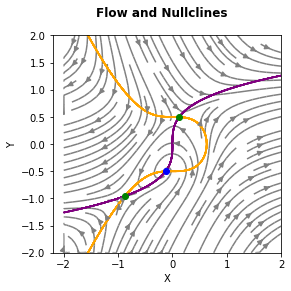

In [26]:
#####################################################################################

# CODE FOR PHASE PORTRAIT (NO STABILITY)

# WORKFLOW:
# 1. Take in a matrix of confirmed fixed points.
# 2. Plot the Nullclines and Flow with the fixed points.

# (THIS IS PROOF OF CONCEPT. WE CAN MAKE THIS BETTER AND BREAK UP THE FUNCTIONS DIFFERENTLY.)

def gen_phase(min_S1, max_S1, min_S2, max_S2, resolution, tolerance, roots):

    x = np.linspace(min_S1, max_S1, resolution)
    y = np.linspace(min_S2, max_S2, resolution)
    X,Y = np.meshgrid(x, y)

    U = S1_ODE(X,Y)
    V = S2_ODE(X,Y)

    F1 = ((S1_ODE(X,Y)<tolerance) & (S1_ODE(X,Y)>-tolerance))
    F2 = ((S2_ODE(X,Y)<tolerance) & (S2_ODE(X,Y)>-tolerance))

    fig, ax = plt.subplots()
    ax.streamplot(X, Y, U, V, color='gray')
    ax.contour(X,Y,F1, colors='orange')
    ax.contour(X,Y,F2, colors='purple')
    ax.set_aspect('equal', 'box')
    for i in range(len(roots)):
        stab = EP_Stability(Jacobian(F), [roots[i]])
        if stab[0] == 0:
            ax.plot(roots[i][0], roots[i][1], 'ro')
        elif stab[0] == 1:
            ax.plot(roots[i][0], roots[i][1], 'bo')
        elif stab[0] == 2:
            ax.plot(roots[i][0], roots[i][1], 'go')
        else:
            ax.plot(roots[i][0], roots[i][1], 'black')
    fig.suptitle('Flow and Nullclines',fontweight="bold")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

guesses = np.array([[0, 0.5], [0, -0.5], [-1, -1]])
roots = find_eqs(guesses)
gen_phase(-2, 2, -2, 2, 4000, 0.001, roots)

Like in our one-dimensional example, there are still **non-hyperbolic** outcomes to our stability analysis. Again, in these special cases, the entire dynamical system is going through a characteristic change known as a **bifurcation** that will dramatically augment the behavior of trajectories within that system.


## Section 4: Unguided Example

Now that we've worked through dynamics in one and two dimensions, let's apply our knowledge to an example system. This is a chance to work through an example on your own, although we will provide some starter code for each question. The check questions at the end can help you determine if you are on the right track, but you should try to work through each part of the problem on your own first. If you want the extra challenge, you should try to do this by hand instead of using the code!

Here is the system of equations:

$$
\frac{𝑑A}{𝑑𝑡}= A^2 - B
$$

$$
\frac{𝑑B}{𝑑𝑡}= A^3 - 2A + B^2
$$

*Assume we are interested in a range of values for both state variables A and B between 0 and 5.*

#### Question 1: What are the Equilibrium Points of this system?

In [1]:
## Define your functions
# f1 = ...
# f2 = ...
# F = [f1,f2]

## Then correctly implement the find_eqs function 
## ...

## find_eqs(guesses)

#### Question 2: What is the Jacobian Matrix of this system?

In [2]:
## Calculate the Jacobian using a function we have described

# J = ...

#### Question 3: What are the Eigenvalues of the Jacobian Matrix at each EP?

In [4]:
# list(J.eigenvals())

## Evaluate the eigenvalues at each point found above

# ...

#### Question 4: What are the stabilities of each EP?

In [5]:
## Use the EP_Stability function to determine the stability of each equilibrium point

To check your answers, you can run [this notebook](https://github.com/eforbes24/tellurium-nanohub-base/blob/main/DST_COG_Unguided_Answers.ipynb) on Github.

## Section 5: Further Resources

This notebook provides a bare-bones introduction to dynamical systems for those interested in finding equilibria in simple chemical systems. That being said, dynamical systems is an expansive research area with dimensionality and application far beyond what we have covered here. Below we have listed several resources that you can use to learn more about dynamical systems and how they can be applied to biological systems.

### Relevant Textbooks
Strogatz SH. Nonlinear Dynamics and Chaos: With Applications to Physics, Biology, Chemistry, and Engineering. Westview Press; 2014.

Modeling Life: The Mathematics of Biological Systems. Springer; 2014.

Sauro HM, Systems Biology: Introduction to Pathway Modeling. Cambridge University Press; 2014.

### Relevant Video Lectures & Lessons
https://compneuro.neuromatch.io/tutorials/intro.html

https://modelinginbiology.github.io/Videos/ 

https://www.youtube.com/watch?v=9fQkLQZe3u8 

https://www.youtube.com/playlist?list=PLZHQObOWTQDMsr9K-rj53DwVRMYO3t5Yr 
